In [64]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from preprocessing import silence_removal, noise_reduction
from feature_extraction.mfcc import MFCC
from models.svm import SVM
from audio import Audio

original_metadata_path = os.path.join(".", "data", "original_data_labeled.tsv")
filtered_metadata_path = os.path.join(".", "data", "filtered_data_labeled.tsv")
audio_dir = os.path.join(".", "data", "filtered_clips")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Clean and Load Dataset

Remove records of erroneous data (e.g. missing or corrupted audio files) from the dataset.

In [ ]:
if not os.path.exists(filtered_metadata_path):
  df = pd.read_csv(original_metadata_path, sep='\t')

  # Remove unnecessary columns
  df.drop(columns=['client_id', 'sentence', 'age', 'gender', 'accent'], inplace=True, errors='ignore')

  # Filter out rows with missing labels
  df = df[df['label'].notna()]

  with open('error_file_paths.txt', 'r') as f:
      error_file_paths = f.read().splitlines()

  # Convert file paths to just the filename portion
  error_file_paths = [os.path.basename(path) for path in error_file_paths]

  # Remove rows with file paths in the error_file_paths list
  df.drop(df[df['path'].isin(error_file_paths)].index, inplace=True)

  valid_indices = []
  for idx, row in tqdm(df.iterrows(), total=len(df), desc="Checking files"):
    file_path = os.path.join(audio_dir, row['path'])
    if os.path.exists(file_path):
      valid_indices.append(idx)

  # Use only records with existing files
  df = df.loc[valid_indices]

  # Save the filtered DataFrame to a new TSV file
  df.to_csv(filtered_metadata_path, sep='\t', index=False)
else:
  df = pd.read_csv(filtered_metadata_path, sep='\t')

### Visualizations

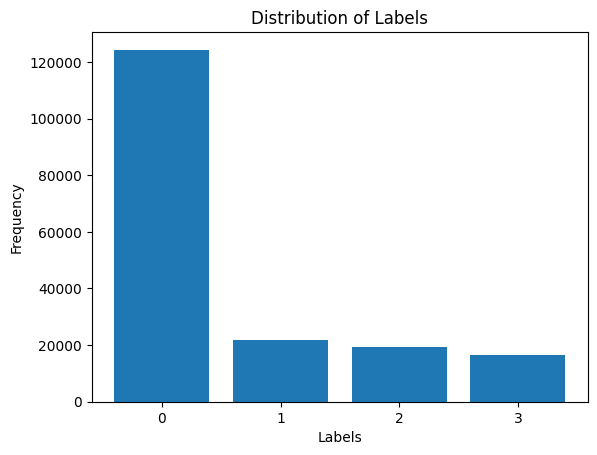

In [ ]:
# Get sorted unique labels
labels = sorted(df['label'].unique())

# Define bin edges so bars are centered on labels
bin_edges = np.arange(min(labels) - 0.5, max(labels) + 1.5, 1)

plt.hist(df['label'], bins=bin_edges, rwidth=0.8)
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Distribution of Labels')
plt.xticks(labels)  # Set ticks to the actual labels
plt.show()

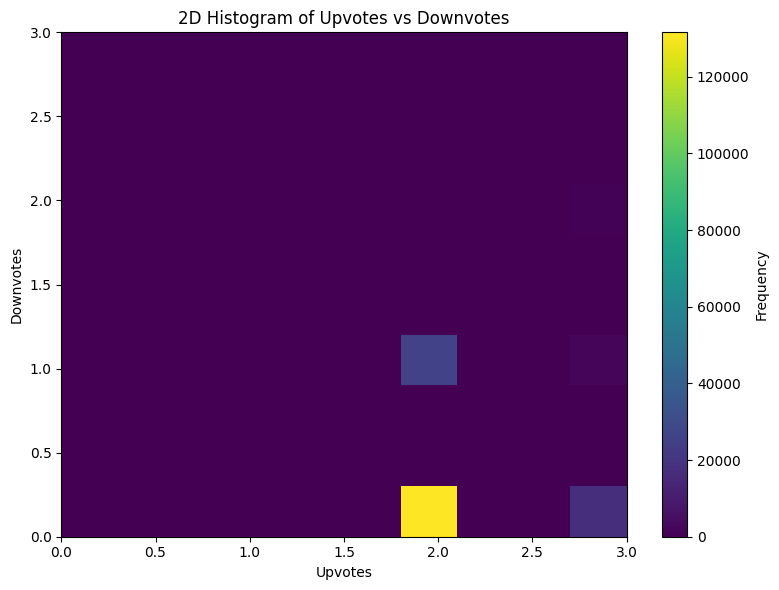

In [44]:
import matplotlib.pyplot as plt

# Create a 2D histogram (heatmap) of upvotes vs downvotes
plt.figure(figsize=(8, 6))
plt.hist2d(df['up_votes'], df['down_votes'], bins=(10, 10), range=[(0, 3), (0, 3)], cmap='viridis')
plt.colorbar(label='Frequency')

plt.title("2D Histogram of Upvotes vs Downvotes")
plt.xlabel("Upvotes")
plt.ylabel("Downvotes")
plt.tight_layout()

plt.show()

Loading Training data

In [ ]:
samples = 2000 # df['label'].value_counts().min()
balanced_samples = pd.DataFrame()
for cls in range(4):
    cls_df = df[df['label'] == cls]
    sampled = cls_df.sample(n=samples, random_state=42)  # Random sampling
    balanced_samples = pd.concat([balanced_samples, sampled])

def load_audio_file(file_path):
    try:
        return librosa.load(file_path)
    except Exception as e:
        return None, None

X, Y = [], []
error = 0
for row in tqdm(balanced_samples.itertuples(), desc="Loading audio files"):
    audio, sr = load_audio_file(os.path.join(audio_dir, row.path))

    if audio is None:
        error += 1
    else:
        x = Audio(audio, sr)
        X.append(x)
        Y.append(row.label)

print("Error = ", error)

Loading audio files: 8000it [01:39, 80.24it/s] 

Error =  0


In [46]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y
)

### Pipeline

In [47]:
noise_reducer = noise_reduction.NoiseReducer()
silence_remover = silence_removal.SilenceRemover()
mfcc = MFCC()
svm = SVM()

pipe = make_pipeline(noise_reducer, silence_remover, mfcc, svm, verbose=True) 
pipe

Pipeline(steps=[('noisereducer', NoiseReducer()),
                ('silenceremover', SilenceRemover()), ('mfcc', MFCC()),
                ('svm', SVM(config={}))],
         verbose=True)

In [48]:
pipe = pipe.fit(X_train, np.array(y_train))
y_pred = pipe.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Noise Reduction: 100%|██████████| 1600/1600 [01:42<00:00, 15.62it/s]


[Pipeline] ...... (step 1 of 4) Processing noisereducer, total= 1.7min
[Pipeline] .... (step 2 of 4) Processing silenceremover, total=   3.0s


Extracting MFCCs: 100%|██████████| 1600/1600 [00:17<00:00, 90.00it/s] 


[Pipeline] .............. (step 3 of 4) Processing mfcc, total=  17.8s
[Pipeline] ............... (step 4 of 4) Processing svm, total=   0.2s


Extracting MFCCs: 100%|██████████| 400/400 [00:04<00:00, 92.76it/s] 


Accuracy: 0.4175

Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.47      0.47       100
           1       0.49      0.25      0.33       100
           2       0.44      0.36      0.40       100
           3       0.35      0.59      0.44       100

    accuracy                           0.42       400
   macro avg       0.44      0.42      0.41       400
weighted avg       0.44      0.42      0.41       400


Confusion Matrix:
[[47  1 33 19]
 [10 25  2 63]
 [30  8 36 26]
 [14 17 10 59]]


In [60]:
from joblib import dump
import time
import os
import json

# Create a folder for the model
timestamp = time.strftime("%d_%m_%Y_T%H_%M_%S")
model_folder = f'trials/model_{timestamp}'
os.makedirs(model_folder, exist_ok=True)

# Save the model
model_path = os.path.join(model_folder, 'model.joblib')
dump(pipe, model_path)

# Save evaluation metrics
evaluation = {
  "architecture": str([step[0] for step in pipe.steps]),
  "samples_per_class": samples,
  "accuracy": float(accuracy_score(y_test, y_pred)),
  "classification_report": classification_report(y_test, y_pred, output_dict=True),
  "confusion_matrix": confusion_matrix(y_test, y_pred).tolist()
}

# Save evaluation as JSON
eval_path = os.path.join(model_folder, 'evaluation.json')
with open(eval_path, 'w') as f:
  json.dump(evaluation, f, indent=4)

print(f"Model and evaluation saved in folder: {model_folder}")

Model and evaluation saved in folder: trials/model_12_04_2025_T20_35_14
